# Part 3: Weed Detection

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
 
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import os

from keras.layers import Dense, Conv2D, Dropout, MaxPooling2D, Flatten, BatchNormalization, Activation
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
os.chdir("/content/drive/MyDrive/MLSEM6Proj")
os.getcwd()

'/content/drive/MyDrive/MLSEM6Proj'

In [ ]:
batch_size = 32
img_height = 180
img_width = 180
data_dir = "dataset"
image_size=(img_height, img_width)

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 15354 files belonging to 4 classes.
Using 12284 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 15354 files belonging to 4 classes.
Using 3070 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['broadleaf', 'grass', 'soil', 'soyabean']


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

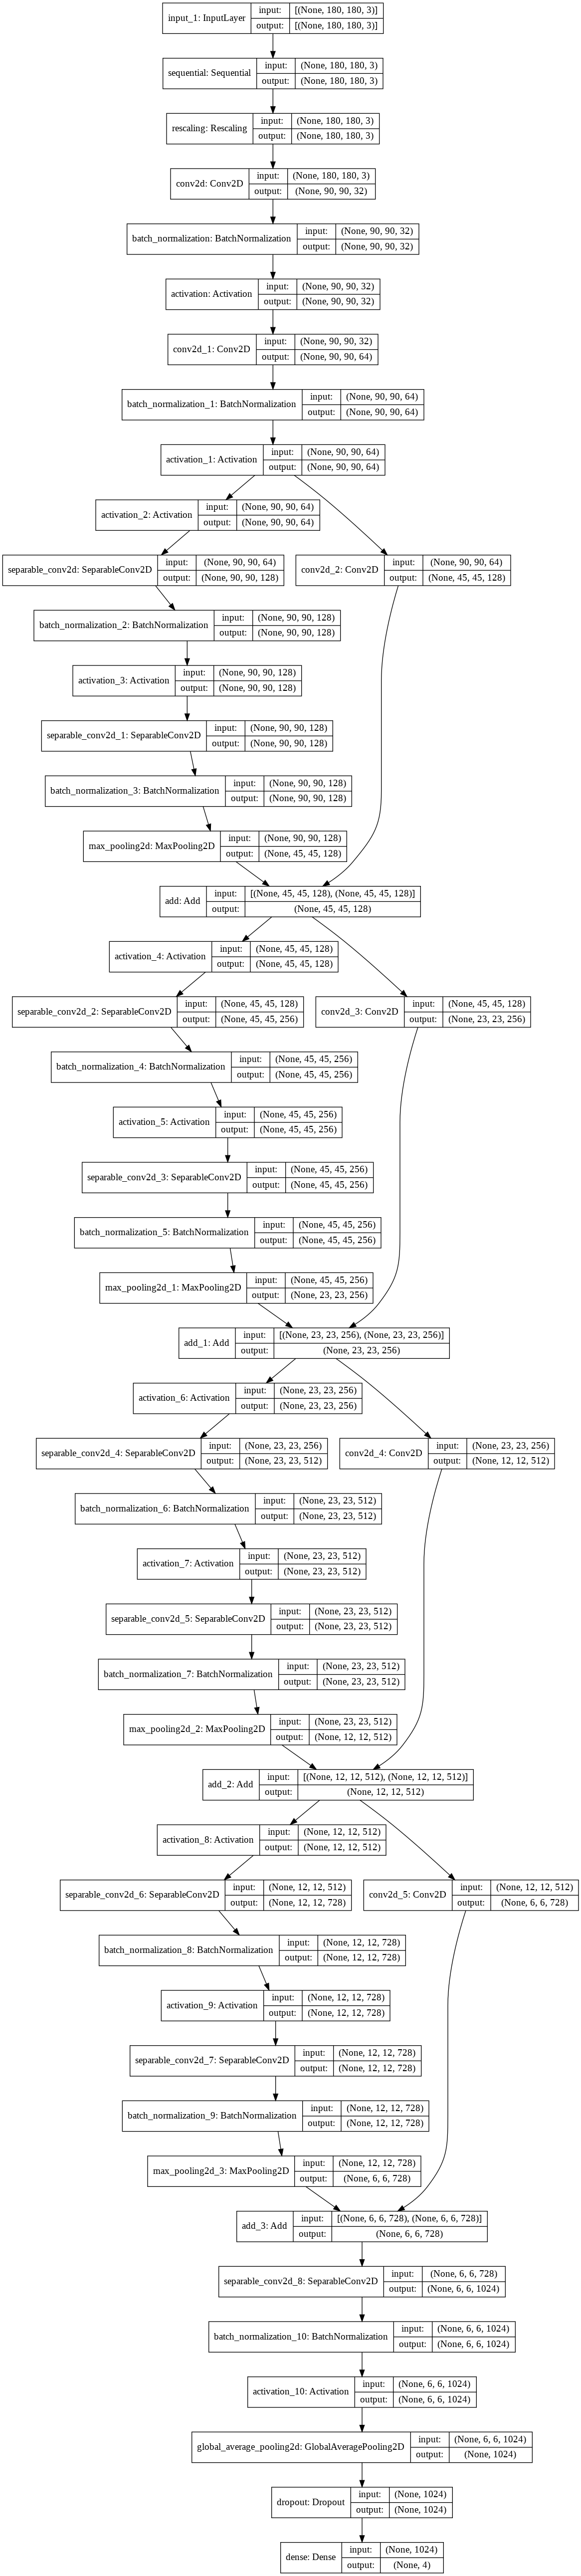

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=4)
keras.utils.plot_model(model, show_shapes=True)

# num_classes = 4

# model = Sequential([
#   layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
#   layers.Conv2D(16, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(32, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(64, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Flatten(),
#   layers.Dense(128, activation='relu'),
#   layers.Dense(num_classes, activation='softmax')
# ])

In [ ]:
# model.compile(
#     optimizer=keras.optimizers.Adam(1e-3),
#     loss="binary_crossentropy",
#     metrics=["accuracy"],
# )

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 180, 180, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 180, 180, 3)  0           sequential[0][0]                 
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 90, 90, 32)   896         rescaling[0][0]                  
______________________________________________________________________________________________

In [ ]:
# epochs=5
# history = model.fit(
#   train_ds,
#   validation_data=val_ds,
#   epochs=epochs
# )

In [ ]:
# os.chdir("/content/drive/MyDrive/Amdocs/Epoch_Save")
# os.getcwd()

In [ ]:
epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
)

Epoch 1/5
384/384 [==============================] - 3278s 9s/step - loss: 0.1288 - accuracy: 0.9564 - val_loss: 0.1280 - val_accuracy: 0.9609
Epoch 2/5
384/384 [==============================] - 3258s 8s/step - loss: 0.0725 - accuracy: 0.9753 - val_loss: 0.1181 - val_accuracy: 0.9577
Epoch 3/5
384/384 [==============================] - 3272s 9s/step - loss: 0.0674 - accuracy: 0.9784 - val_loss: 0.8523 - val_accuracy: 0.8134
Epoch 4/5
320/384 [========================>.....] - ETA: 8:30 - loss: 0.0595 - accuracy: 0.9817

KeyboardInterrupt: ignored

DID KeyboardInterrupt 

Cause the model became perfect due to usage of Xception Network

And the model saved at epoch one !

In [ ]:
# model.save("adam_FT2_e5_2Mp.h5")

Now time to see it's working!

In [ ]:
from keras.models import load_model
batch_size = 32
img_height = 180
img_width = 180
data_dir = "dataset"
image_size=(img_height, img_width)
model = load_model(r'adam_FT2_e5_2Mp.h5')

In [ ]:
img = keras.preprocessing.image.load_img(
    "dataset/broadleaf/broadleaf_124.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
# img_array = tf.expand_dims(img_array, 0)  # Create batch axis
# img_array = img_array.reshape((180, 180, 3))
img_array = img_array[np.newaxis]
# img_array.shape
predictions = model.predict(img_array)
score = predictions[0]

print("score = ",score)
print("predictions = ",predictions)

['broadleaf', 'grass', 'soil', 'soyabean']

score =  [9.9992752e-01 1.9231791e-05 7.4619260e-07 5.2553507e-05]
predictions =  [[9.9992752e-01 1.9231791e-05 7.4619260e-07 5.2553507e-05]]


['broadleaf', 'grass', 'soil', 'soyabean']

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


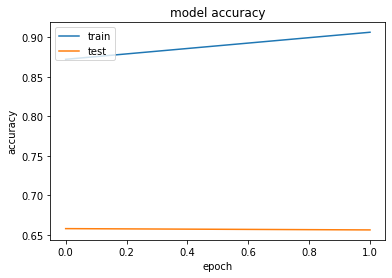

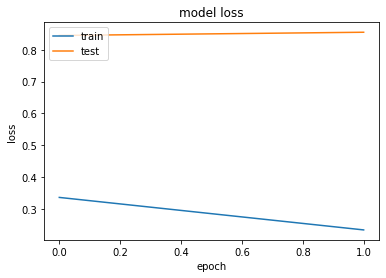

In [ ]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()